# 

#  <span style="color:lightblue" font="bold"> Baseline Tumor Categorization </span>

## Import Block

In [45]:
### Importing the necessary libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image

## Data Loading and Processing Block

#### 1. <span style="color:lightblue" font="bold"> Loading the dataset </span>

##### 1.2 Loading Paths to images

In [46]:
# Define the path to the classification dataset (relative to the notebook location)
data_dir = Path("../raw_data/classification/Training")
test_dir = Path("../raw_data/classification/Testing")
os.listdir(data_dir)
os.listdir(test_dir)


['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

#### 1.1 Removing duplicates

In [47]:
from pathlib import Path
import hashlib
import os

# --- Paramès ---
DATASET_ROOT = Path("../raw_data/classification")  # dossier racine contenant Training/ et Testing/
CLASSES = ["glioma", "pituitary", "meningioma", "notumor"]
SPLITS_ORDER = ["Training", "Testing"]  # Priorité : on garde ce qu'on voit en premier
EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")  # adapte si besoin
DRY_RUN = False  # Mettre False pour réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    for split in SPLITS_ORDER:  # Training d'abord, puis Testing
        for cls in CLASSES:
            folder = DATASET_ROOT / split / cls
            if not folder.exists():
                print(f"⚠️ Dossier absent : {folder}")
                continue
            for ext in EXTENSIONS:
                all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 13899
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
Scanné 6000 fichiers...
Scanné 6500 fichiers...
Scanné 7000 fichiers...
Scanné 7500 fichiers...
Scanné 8000 fichiers...
Scanné 8500 fichiers...
Scanné 9000 fichiers...
Scanné 9500 fichiers...
Scanné 10000 fichiers...
Scanné 10500 fichiers...
Scanné 11000 fichiers...
Scanné 11500 fichiers...
Scanné 12000 fichiers...
Scanné 12500 fichiers...
Scanné 13000 fichiers...
Scanné 13500 fichiers...
✅ Aucun doublon exact trouvé.


##### 1.3 Creating a dataframe of images paths and labels

In [48]:
# Collect image paths and their corresponding tumor types
image_paths = []
labels = []

for tumor_type in os.listdir(data_dir):
    tumor_type_path = data_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for img_name in os.listdir(tumor_type_path):
            img_path = tumor_type_path / img_name
            # Optional: filter only image files
            if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                image_paths.append(str(img_path))
                labels.append(tumor_type)

# Create a DataFrame for the dataset
df = pd.DataFrame({
    "image_path": image_paths,
    "tumor_type": labels
})

# Show the first few rows for verification
print(df.shape)
df.head(10)


(11410, 2)


,image_path,tumor_type
0,../raw_data/classification/Training/pituitary/...,pituitary
1,../raw_data/classification/Training/pituitary/...,pituitary
2,../raw_data/classification/Training/pituitary/...,pituitary
3,../raw_data/classification/Training/pituitary/...,pituitary
4,../raw_data/classification/Training/pituitary/...,pituitary
5,../raw_data/classification/Training/pituitary/...,pituitary
6,../raw_data/classification/Training/pituitary/...,pituitary
7,../raw_data/classification/Training/pituitary/...,pituitary
8,../raw_data/classification/Training/pituitary/...,pituitary
9,../raw_data/classification/Training/pituitary/...,pituitary


#### 2. Label Encoding Tumor Types

In [49]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3}

df["tumor_type_encoded"] = df["tumor_type"].map(mapping)
df.head()

,image_path,tumor_type,tumor_type_encoded
0,../raw_data/classification/Training/pituitary/...,pituitary,3
1,../raw_data/classification/Training/pituitary/...,pituitary,3
2,../raw_data/classification/Training/pituitary/...,pituitary,3
3,../raw_data/classification/Training/pituitary/...,pituitary,3
4,../raw_data/classification/Training/pituitary/...,pituitary,3


#### 3. Preparing the training and validation sets

3.1 Defining data augmentation and processing functions

In [50]:
# Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

In [51]:
# Loading images without preprocessing
from tensorflow.lite.python import convert
def load_image(path):
    img = Image.open(path)
    arr = np.array(img, dtype=np.float32)
    return arr

In [52]:
loadtest = load_image(df.image_path[0])
loadtest.shape

(224, 224, 3)

In [53]:
# Load image with processing and data augmentation
import tensorflow as tf
target_size = (224, 224)
def load_process_image(path, target_size=(224, 224), augment=True):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, target_size)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        
    return tf.clip_by_value(img, 0.0, 1.0)

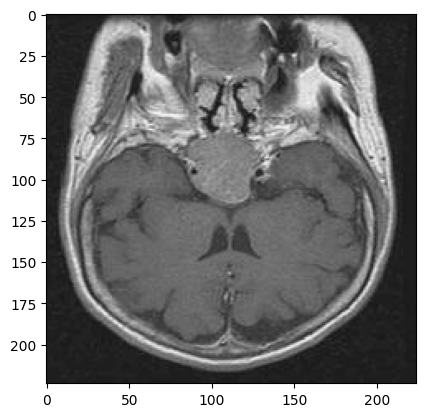

In [54]:
loadtest = load_process_image(df.image_path[0])
loadtest.shape
plt.imshow(loadtest)

3.2 Defining train and val dataframes

In [55]:
# Split df into train df and validation df
df_train, df_val = train_test_split(
    df,
    test_size=0.2, 
    stratify=df["tumor_type_encoded"],  # keep class balance
    random_state=42)

df_train.shape, df_val.shape

((9128, 3), (2282, 3))

In [56]:
# Preparing the training dataset

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
paths = df_train["image_path"].values.astype(str)
labels = df_train["tumor_type_encoded"].values.astype("int32")

train_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
train_ds = train_ds.shuffle(len(paths))
train_ds = train_ds.map(
    lambda x, y: (load_process_image(x, augment=True), y),
    num_parallel_calls=AUTOTUNE,
)
train_ds = train_ds.batch(batch_size).prefetch(AUTOTUNE)
print("✅ train_ds created and of type = ", type(train_ds))

✅ train_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [57]:
val_paths = df_val["image_path"].values.astype(str)
val_labels = df_val["tumor_type_encoded"].values.astype("int32")

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(
    lambda x, y: (load_process_image(x, augment=False), y),
    num_parallel_calls=AUTOTUNE,
)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)
print("✅ val_ds created and of type = ", type(val_ds))


✅ val_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


#### 4. Preparing the testing  set

In [58]:
# Collect image paths and their corresponding tumor types
from scipy import test


test_paths = []
test_labels = []

for tumor_type in os.listdir(test_dir):
    tumor_type_path = test_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for test_img_name in os.listdir(tumor_type_path):
            test_img_path = tumor_type_path / test_img_name
            # Optional: filter only image files
            if test_img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                test_paths.append(str(test_img_path))
                test_labels.append(tumor_type)

# Create a DataFrame for the dataset
test_df = pd.DataFrame({
    "test_image_path": test_paths,
    "test_tumor_type": test_labels
})

# adding the encoded tumor type
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

test_df["test_tumor_type_encoded"] = test_df["test_tumor_type"].map(mapping)
test_df

,test_image_path,test_tumor_type,test_tumor_type_encoded
0,../raw_data/classification/Testing/pituitary/B...,pituitary,3
1,../raw_data/classification/Testing/pituitary/T...,pituitary,3
2,../raw_data/classification/Testing/pituitary/T...,pituitary,3
3,../raw_data/classification/Testing/pituitary/B...,pituitary,3
4,../raw_data/classification/Testing/pituitary/M...,pituitary,3
...,...,...,...
2490,../raw_data/classification/Testing/meningioma/...,meningioma,1
2491,../raw_data/classification/Testing/meningioma/...,meningioma,1
2492,../raw_data/classification/Testing/meningioma/...,meningioma,1
2493,../raw_data/classification/Testing/meningioma/...,meningioma,1


In [59]:
# Preparing the test dataset

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

paths = test_df["test_image_path"].values.astype(str)
labels = test_df["test_tumor_type_encoded"].values.astype("int32")

test_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
test_ds = test_ds.map(
    lambda x, y: (load_process_image(x, augment=False), y),
    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

print("✅ test_ds created and of type = ", type(test_ds))

✅ test_ds created and of type =  <class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


## Model Block

In [ ]:
# Model input variables
img_size = 224
input_shape = (img_size, img_size, 3)
num_classes = df_train["tumor_type_encoded"].nunique()

#### 4. Baseline Model Training

##### 4.1 Baseline Initializer and compiler

In [ ]:
# Baseline model 

def init_baseline(input_shape, num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Global pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Small dense head
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [81]:
# Model compiler - used for all models 
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model


##### 4.2 Model training

In [1]:
'''
# Model initialization & summary
baseline = init_baseline(input_shape=input_shape, num_classes=num_classes)
baseline.summary()
'''

'\n# Model initialization & summary\nbaseline = init_baseline(input_shape=input_shape, num_classes=num_classes)\nbaseline.summary()\n'

In [ ]:
'''
# Model training
baseline = compile_model(baseline)
es = EarlyStopping(patience=3, restore_best_weights=True)

    # Set memory growth on all available GPUs
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

history = baseline.fit(train_ds,
                    epochs=5,
                    batch_size=64,
                    validation_data= val_ds,
                    verbose=1,
                    callbacks=[es])
'''                    


TensorFlow version: 2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/5
286/286 [==============================] - 19s 65ms/step - loss: 1.3285 - accuracy: 0.3649 - val_loss: 1.2777 - val_accuracy: 0.4176
Epoch 2/5
286/286 [==============================] - 19s 66ms/step - loss: 1.2487 - accuracy: 0.4362 - val_loss: 1.2385 - val_accuracy: 0.4089
Epoch 3/5
286/286 [==============================] - 22s 77ms/step - loss: 1.2095 - accuracy: 0.4643 - val_loss: 1.1722 - val_accuracy: 0.4820
Epoch 4/5
286/286 [==============================] - 23s 79ms/step - loss: 1.1965 - accuracy: 0.4721 - val_loss: 1.1534 - val_accuracy: 0.5118
Epoch 5/5
286/286 [==============================] - 22s 78ms/step - loss: 1.1799 - accuracy: 0.4897 - val_loss: 1.1193 - val_accuracy: 0.5337


##### 4.3 Model evaluation and confusion matrix

In [ ]:
'''results = baseline.evaluate(test_ds, batch_size=32)
results
'''

78/78 [==============================] - 2s 25ms/step - loss: 1.1356 - accuracy: 0.5411


[1.1356070041656494, 0.5410821437835693]

78/78 [==============================] - 2s 24ms/step


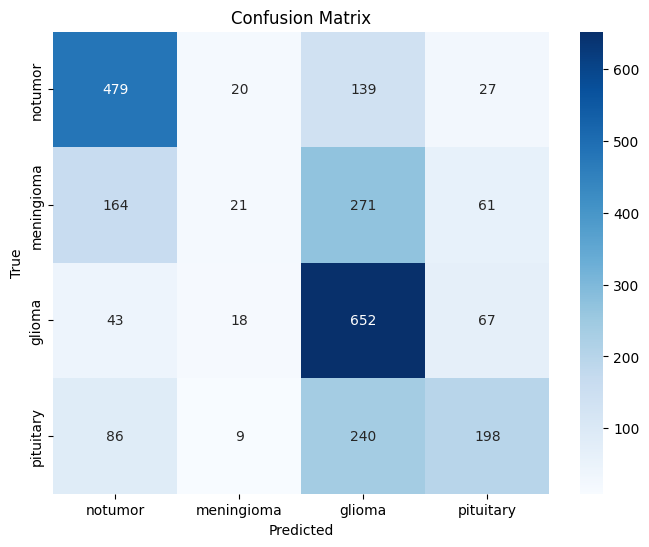

In [ ]:
'''from sklearn.metrics import confusion_matrix

# 1. Prédictions
y_proba = baseline.predict(test_ds)
y_pred = np.argmax(y_proba, axis=1)

y_true_batches = []
for _, y_batch in test_ds:
    y_true_batches.append(y_batch.numpy())
y_true = np.concatenate(y_true_batches, axis=0)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tumor_type_labels,
            yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()'''

#### 5. Transfer learning with ResNet

##### 5.1 Base ResNet model (no fine-tuning) initializer

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


def init_resnet():
    
    resnet = ResNet50(input_shape=input_shape, 
                            weights='imagenet', 
                            include_top=False)

    for layer in resnet.layers:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)

    return model
    

In [ ]:
model = init_resnet()
model.summary()
model = compile_model(model)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               262272    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                           

##### 5.2 Model training

In [86]:
es = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
history_inc = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=10, 
                        callbacks=es)

Epoch 1/10
286/286 [==============================] - 22s 77ms/step - loss: 1.3936 - accuracy: 0.6971 - val_loss: 0.5422 - val_accuracy: 0.8269
Epoch 2/10
286/286 [==============================] - 21s 72ms/step - loss: 0.9491 - accuracy: 0.7423 - val_loss: 0.4558 - val_accuracy: 0.8348
Epoch 3/10
286/286 [==============================] - 21s 73ms/step - loss: 0.7208 - accuracy: 0.7723 - val_loss: 0.4137 - val_accuracy: 0.8449
Epoch 4/10
286/286 [==============================] - 21s 74ms/step - loss: 0.6234 - accuracy: 0.7847 - val_loss: 0.3845 - val_accuracy: 0.8585
Epoch 5/10
286/286 [==============================] - 21s 72ms/step - loss: 0.5392 - accuracy: 0.8078 - val_loss: 0.4303 - val_accuracy: 0.8422
Epoch 6/10
286/286 [==============================] - 21s 73ms/step - loss: 0.5143 - accuracy: 0.8109 - val_loss: 0.4104 - val_accuracy: 0.8405
Epoch 7/10
286/286 [==============================] - 21s 73ms/step - loss: 0.4995 - accuracy: 0.8191 - val_loss: 0.4325 - val_accuracy:

##### 5.3 Model evaluation and confusion matrix

In [87]:
results_inc = model.evaluate(test_ds, batch_size=32)
results_inc

78/78 [==============================] - 5s 62ms/step - loss: 0.4915 - accuracy: 0.7948


[0.49150457978248596, 0.7947895526885986]

In [88]:
y_pred_inc = model.predict(test_ds)

78/78 [==============================] - 6s 59ms/step


In [89]:
y_pred_inc = np.argmax(y_pred_inc, axis=1)


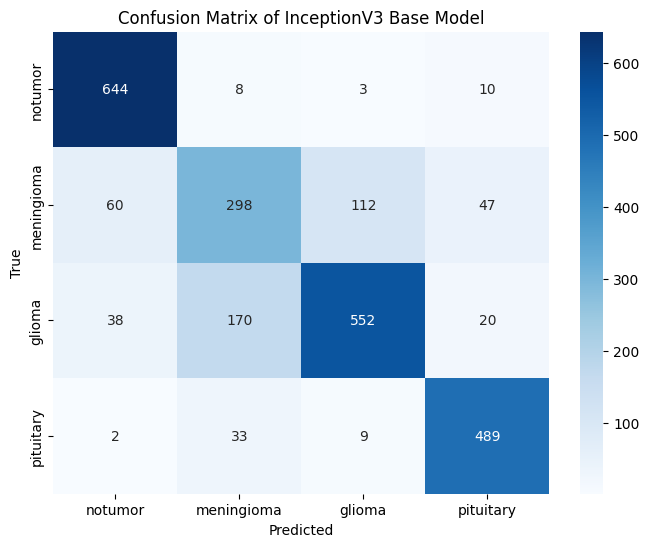

In [90]:
from sklearn.metrics import confusion_matrix


y_true_batches = []
for _, y_batch in test_ds:
    y_true_batches.append(y_batch.numpy())
y_true = np.concatenate(y_true_batches, axis=0)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred_inc)

plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=tumor_type_labels,
            yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of InceptionV3 Base Model")
plt.show()